# 📂 Importing Required Libraries
This section imports essential libraries for model building, training, and visualization.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# **📂 Mounting Google Drive**                                                                         
This section mounts Google Drive to access stored files


In [3]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive


Mounted at /content/drive


**📥 Loading and Inspecting Data**                                                          

This section loads the dataset from Google Drive and checks its structure.


In [4]:
import pandas as pd

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/GP-FER/finaldataset.csv')

# Display the first few rows
data.head()

# Show column names
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

**🔢 Processing Pixel Data**                                                      
Converts pixel data from string format into a NumPy array and normalizes values.


In [5]:
import numpy as np

# Convert pixel values into a NumPy array and normalize
data['pixels'] = data[' pixels'].apply(lambda x: np.array(x.split(), dtype=np.float32) / 255.0)

**✂ Splitting the Dataset**                                                      
Categorizes data into training, validation, and test sets.


In [6]:
# Extract the column that contains split categories
splitter_column = data.iloc[:,1]

# Split the dataset
training_data = data[splitter_column == 'Training']
validation_data = data[splitter_column == 'PublicTest']
test_data = data[splitter_column == 'PrivateTest']

**⚙ Preprocessing Data**                                                       
Reshapes image data and converts labels to categorical format.


In [7]:
from tensorflow.keras.utils import to_categorical

# Function to preprocess images
def preprocess(data):
    images = np.array(data['pixels'].tolist()).reshape(-1, 48, 48, 1)
    return images

# Prepare input datasets
x_train = preprocess(training_data)
x_val = preprocess(validation_data)
x_test = preprocess(test_data)

# Convert labels to categorical format for classification
y_train = to_categorical(training_data['emotion'].values, num_classes=7)
y_val = to_categorical(validation_data['emotion'].values, num_classes=7)
y_test = to_categorical(test_data['emotion'].values, num_classes=7)

**🔍 Checking Label Data** :
Prints sample label values and maps emotions to numeric indices.


In [8]:
# Display first few labels in the training dataset
print(y_train[:7])  # Show numeric labels
print(np.unique(y_train))  # Show all unique label values

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
[0. 1.]


In [9]:
# Extract unique emotion labels and map them to numeric indices
unique_labels = np.unique(training_data['emotion'])
indices = [training_data['emotion'].tolist().index(label) for label in unique_labels]

class_indices = {label: index for index, label in enumerate(unique_labels)}

# Print the label-index mapping
print(class_indices)

{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6}


# **🏗 Loading Pre-trained Model**
Loads a saved deep learning model from Google Drive.


In [10]:
from tensorflow import keras

# Load pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/GP-FER/xception_model2.h5')


**🖼 Data Augmentation**                                                                                          
Applies random transformations to training images to improve model generalization.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation techniques
train_generator = ImageDataGenerator(
    rotation_range=30,  # Random rotation within 30 degrees
    width_shift_range=0.2,  # Horizontal shift up to 20%
    height_shift_range=0.2,  # Vertical shift up to 20%
    zoom_range=0.2,  # Zoom up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels with nearest values
)

# 🏗 Building the Xception Model Architecture
This section defines the entry flow, middle flow, and exit flow for model construction.


In [12]:
def entry_flow(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, and 3 follow a similar pattern, increasing feature depth
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

In [13]:
def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)  # Apply dropout for regularization

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

In [14]:
def exit_flow(x, num_classes=7):
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

# Construct the full model
inputs = keras.Input(shape=(48, 48, 1))  # Define input shape
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

**📊 Model Training Configuration**           

Defines optimizer, loss function, and checkpoints


In [15]:
from keras.callbacks import ModelCheckpoint

# Define optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')

**🔄 Data Augmentation**          
Creates a data generator to apply transformations for training robustness.


In [16]:
train_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
batch_size = 64

# Define data loaders
train_loader = train_generator.flow(x_train, y_train, batch_size=batch_size)
val_loader = (x_val, y_val)

**🏋 Model Training**               
Executes model training in multiple phases with adaptive learning rates.


In [17]:
epochs = 100
training1 = xception.fit(train_loader, steps_per_epoch=len(x_train)//batch_size, epochs=epochs, validation_data=val_loader, callbacks=[checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2742 - loss: 1.8896
Epoch 1: val_loss improved from -inf to 1.64755, saving model to best_model.h5


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 156s 95ms/step - accuracy: 0.2743 - loss: 1.8895 - val_accuracy: 0.4193 - val_loss: 1.6476
Epoch 2/100
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 1:55 109ms/step - accuracy: 0.5000 - loss: 1.3177

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.3177 - val_accuracy: 0.4260 - val_loss: 1.6459
Epoch 3/100
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4506 - loss: 1.4392
Epoch 3: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - accuracy: 0.4506 - loss: 1.4391 - val_accuracy: 0.4661 - val_loss: 1.4828
Epoch 4/100
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.4688 - loss: 1.4180
Epoch 4: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 1.4180 - val_accuracy: 0.4583 - val_loss: 1.5165
Epoch 5/100
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5100 - loss: 1.3015
Epoch 5: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 72s 68ms/step - accuracy: 0.5100 - loss: 1.3015 - val_accuracy: 0.4929 - val_loss: 1.6200
Epoch 6/100
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - a

Adjust learning rate and continue training:

In [18]:
xception.optimizer.learning_rate.assign(0.0001)
epochs = 30
training2 = xception.fit(train_loader, steps_per_epoch=len(x_train)//batch_size, epochs=epochs, validation_data=val_loader, callbacks=[checkpoint])

Epoch 1/30
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7991 - loss: 0.5616
Epoch 1: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 71s 67ms/step - accuracy: 0.7991 - loss: 0.5616 - val_accuracy: 0.7799 - val_loss: 0.6329
Epoch 2/30
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 1:06 63ms/step - accuracy: 0.8438 - loss: 0.5591
Epoch 2: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.5591 - val_accuracy: 0.7799 - val_loss: 0.6329
Epoch 3/30
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8214 - loss: 0.5011
Epoch 3: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - accuracy: 0.8214 - loss: 0.5011 - val_accuracy: 0.7885 - val_loss: 0.6202
Epoch 4/30
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.9219 - loss: 0.3418
Epoch 4: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9219 - loss: 0.3418 - val_accuracy:

Further reduce learning rate for final training

In [19]:
xception.optimizer.learning_rate.assign(0.00001)
epochs = 20
training3 = xception.fit(train_loader, steps_per_epoch=len(x_train)//batch_size, epochs=epochs, validation_data=val_loader, callbacks=[checkpoint])

Epoch 1/20
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8544 - loss: 0.4077
Epoch 1: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - accuracy: 0.8544 - loss: 0.4077 - val_accuracy: 0.8044 - val_loss: 0.5715
Epoch 2/20
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 1:00 57ms/step - accuracy: 0.8281 - loss: 0.4832
Epoch 2: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8281 - loss: 0.4832 - val_accuracy: 0.8041 - val_loss: 0.5717
Epoch 3/20
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8568 - loss: 0.4066
Epoch 3: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.8568 - loss: 0.4066 - val_accuracy: 0.8055 - val_loss: 0.5694
Epoch 4/20
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 1:02 59ms/step - accuracy: 0.8594 - loss: 0.4345
Epoch 4: val_loss did not improve from 1.64755
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8594 - loss: 0.4345 - val_accuracy

# 📈 Performance Visualization
Plots loss and accuracy over epochs.


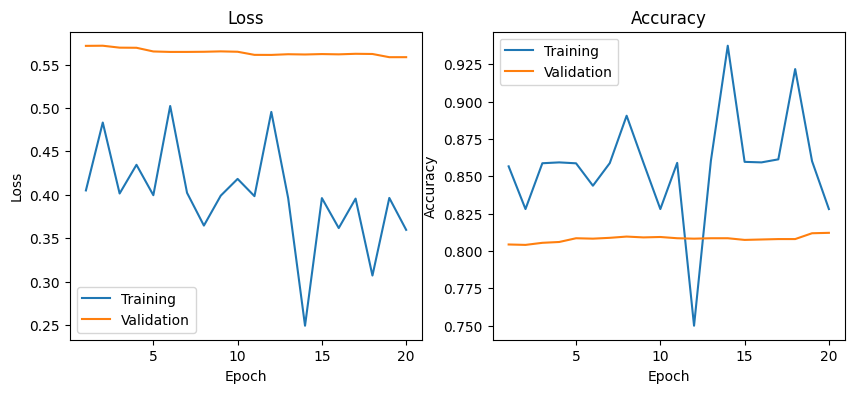

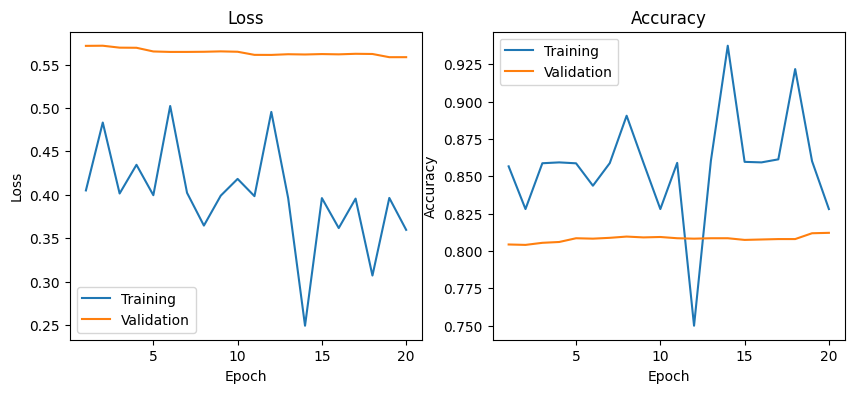

In [20]:
import matplotlib.pyplot as plt

# Plot training history
history = training3.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

***💾 Saving the Model***         
Saves trained model to Google Drive.


In [24]:
xception.save('/content/drive/MyDrive/xception_model2v2.h5')

# 🧠 Model Evaluation and Performance Analysis
This section makes predictions with the trained model, evaluates its performance, and visualizes results using a confusion matrix and a classification report


**🔮 Making Predictions**                                         
Uses the trained model to predict emotions based on the test dataset.


In [30]:
# Make predictions with the model
predicted_probs = model.predict(x_test)  # Get predicted probabilities
predicted_labels = np.argmax(predicted_probs, axis=1)  # Convert probabilities to class labels

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


**📊 Generating Confusion Matrix**                                
Compares model predictions with actual labels to assess performance.


In [31]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)

**🏷 Defining Emotion Classes**                                             
Specifies the emotion categories for analysis


In [32]:
# Define class names corresponding to emotion categories
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

**🎨 Visualizing Confusion Matrix**                                             
Plots the confusion matrix using Seaborn for better readability.


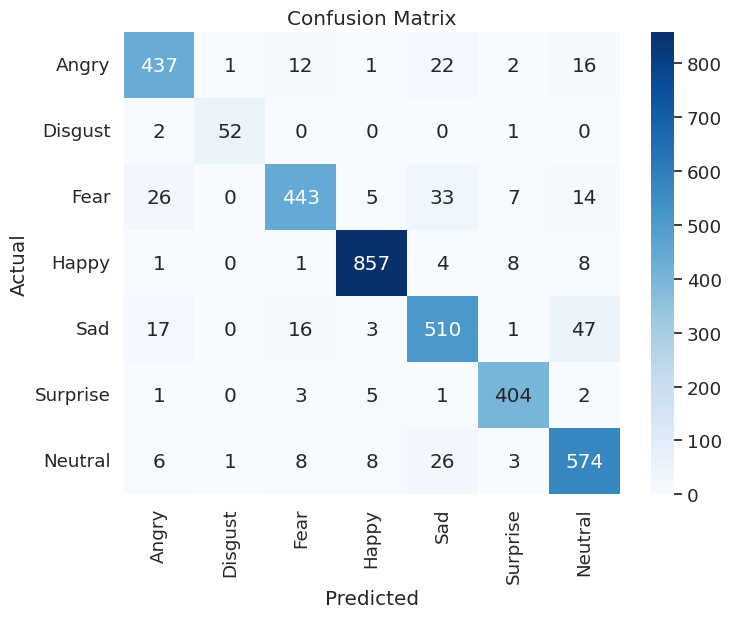

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure plot size and font scale
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Plot confusion matrix with annotations
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Label the axes and add a title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

**📜 Generating Classification Report**                                           
Provides precision, recall, and F1-score for each emotion class.


In [34]:
from sklearn.metrics import classification_report

# Print classification report with detailed metrics
print('Classification Report:')
print(classification_report(np.argmax(y_test, axis=1), predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.89      0.89      0.89       491
     Disgust       0.96      0.95      0.95        55
        Fear       0.92      0.84      0.88       528
       Happy       0.97      0.97      0.97       879
         Sad       0.86      0.86      0.86       594
    Surprise       0.95      0.97      0.96       416
     Neutral       0.87      0.92      0.89       626

    accuracy                           0.91      3589
   macro avg       0.92      0.91      0.92      3589
weighted avg       0.91      0.91      0.91      3589



This section ensures a structured evaluation of model performance, highlighting areas for improvement. Let me know if you need any refinements!
